# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 22, 2018

## Supervised Approaches

# Reading Material

U-Net
Regression Trees in Medical Imaging

# Overview
1. Pipelines
2. Classification
3. Regression
4. Segmentation

# Pipelines

We will use the idea of pipelines generically here to refer to the combination of steps that need to be performed to solve a problem. 

,x,y
48,-2.846085,-0.448240
45,5.481257,-7.533075
37,6.978449,-8.895081
70,7.469452,-6.328131
90,8.068841,-7.208665


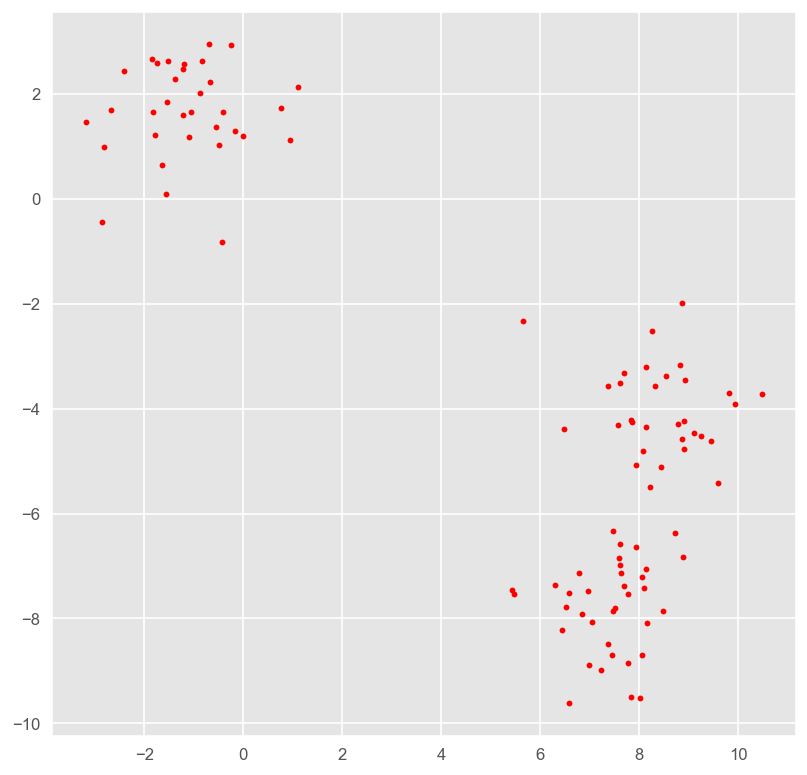

In [1]:
%matplotlib inline
from sklearn.datasets import make_blobs
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid': False})
import matplotlib.pyplot as plt
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 14
plt.style.use('ggplot')
import numpy as np
import pandas as pd

test_pts = pd.DataFrame(make_blobs(n_samples = 100, random_state = 2018)[0], columns=['x', 'y'])
plt.plot(test_pts.x, test_pts.y, 'r.')
test_pts.sample(5)

In [2]:
%%file pipe_utils.py
import matplotlib.pyplot as plt
from skimage.util.montage import montage2d
def display_data(in_ax, in_data, show_hist):
    if len(in_data.shape)==2:
        if show_hist:
            for i in range(in_data.shape[1]):
                in_ax.hist(in_data[:,i], label = 'Dim:{}'.format(i), alpha = 0.5)
            in_ax.legend()
        else:
            if in_data.shape[1]==2:
                in_ax.plot(in_data[:,0], in_data[:,1], 'r.')
            else:
                in_ax.plot(in_data,'.-')
    elif len(in_data.shape)==3:
        if show_hist:
            in_ax.hist(in_data.ravel())
        else:
            in_ax.imshow(montage2d(in_data))
             

def show_pipe(pipe, in_data, show_hist = False):
    m_rows = np.ceil((len(pipe.steps)+1)/3).astype(int)
    fig, t_axs = plt.subplots(m_rows, 3, figsize = (12, 5*m_rows))
    m_axs = t_axs.flatten()
    [c_ax.axis('off') for c_ax in m_axs]
    last_data = in_data
    for i, (c_ax, (step_name, step_op)) in enumerate(zip(m_axs, [('Input Data', None)]+pipe.steps), 1):
        if step_op is not None:
            try:
                last_data = step_op.transform(last_data)
            except AttributeError:
                try:
                    last_data = step_op.predict_proba(last_data)
                except AttributeError:
                    last_data = step_op.predict(last_data)
                
        display_data(c_ax, last_data, show_hist)
        c_ax.set_title('Step {} {}\n{}'.format(i, last_data.shape, step_name))
        c_ax.axis('on')
import numpy as np
from sklearn.preprocessing import FunctionTransformer

flatten_func = lambda x: np.reshape(x,(np.shape(x)[0],-1))
flatten_step = FunctionTransformer(flatten_func, validate = False)

def px_flatten_func(in_x): 
    if len(in_x.shape)==2:
        x = np.expand_dims(in_x, -1)
    elif len(in_x.shape)==3:
        x = in_x
    elif len(in_x.shape)==4:
        x = in_x
    else:
        raise ValueError('Cannot work with images with dimensions {}'.format(in_x.shape))
    return np.reshape(x,(-1, np.shape(x)[-1]))

px_flatten_step = FunctionTransformer(px_flatten_func, validate = False)

def add_xy_coord(in_x):
    if len(in_x.shape)==2:
        x = np.expand_dims(np.expand_dims(in_x, 0), -1)
    elif len(in_x.shape)==3:
        x = np.expand_dims(in_x, -1)
    elif len(in_x.shape)==4:
        x = in_x
    else:
        raise ValueError('Cannot work with images with dimensions {}'.format(in_x.shape))
    n_img, x_dim, y_dim, c_dim = x.shape
    
    _, xx, yy, _ = np.meshgrid(np.arange(n_img), 
                               np.linspace(-1, 1, x_dim), 
                               np.linspace(-1, 1, y_dim), 
                               [1],
                              indexing = 'ij')
    return np.concatenate([x, xx, yy], -1)
xy_step = FunctionTransformer(add_xy_coord, validate = False)

def fit_img_pipe(in_pipe, in_x, in_y):
    in_pipe.fit(in_x, 
                px_flatten_func(in_y)[:,0])
    def predict_func(new_x):
        x_dim, y_dim = new_x.shape[0:2]
        return in_pipe.predict(new_x).reshape((x_dim, y_dim, -1))
    return predict_func

Overwriting pipe_utils.py


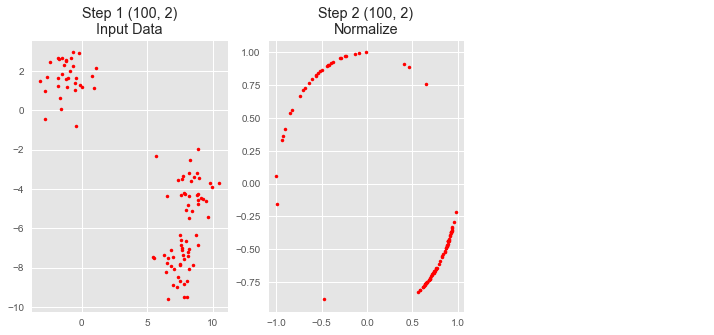

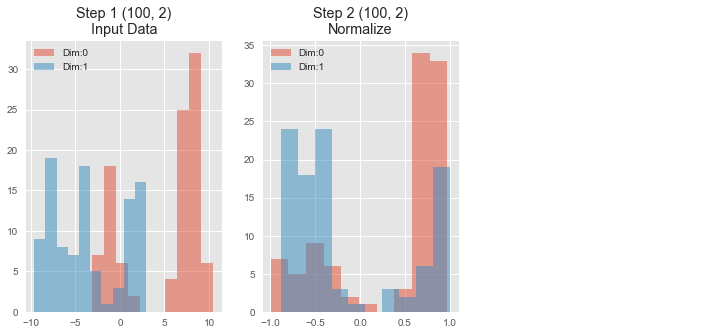

In [3]:
from pipe_utils import show_pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
simple_pipe = Pipeline([('Normalize', Normalizer())])
simple_pipe.fit(test_pts)
ValueError
show_pipe(simple_pipe, test_pts.values)
show_pipe(simple_pipe, test_pts.values, show_hist = True)

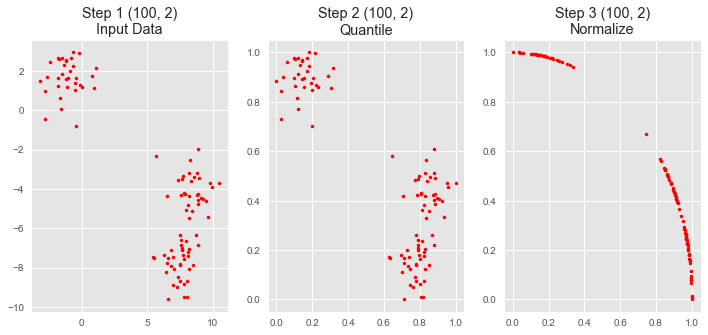

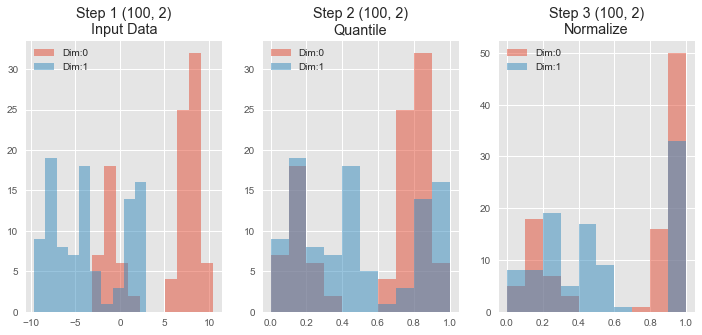

In [4]:
from sklearn.preprocessing import QuantileTransformer
longer_pipe = Pipeline([ ('Quantile', QuantileTransformer(2)),
                        ('Normalize', Normalizer())
                      ])
longer_pipe.fit(test_pts)

show_pipe(longer_pipe, test_pts.values)
show_pipe(longer_pipe, test_pts.values, show_hist = True)

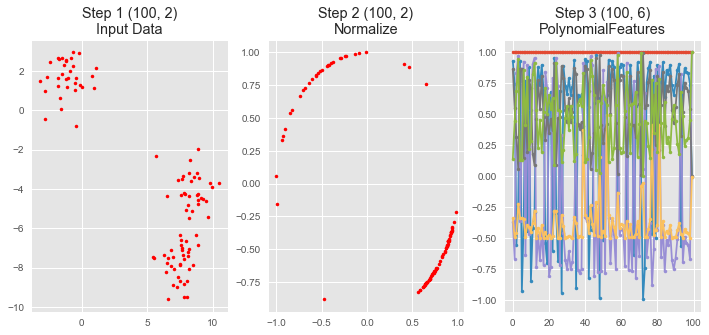

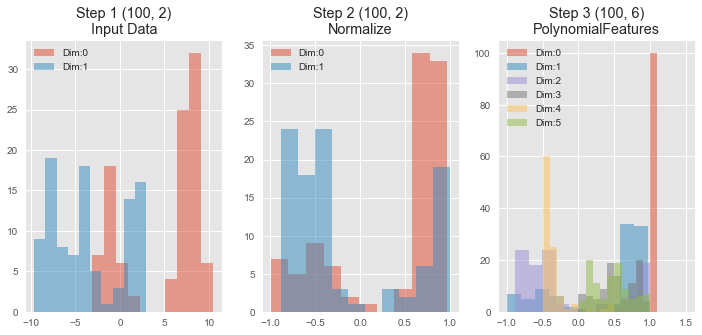

In [5]:
from sklearn.preprocessing import PolynomialFeatures
messy_pipe = Pipeline([
    ('Normalize', Normalizer()),
    ('PolynomialFeatures', PolynomialFeatures(2)),
                      ])
messy_pipe.fit(test_pts)

show_pipe(messy_pipe, test_pts.values)
show_pipe(messy_pipe, test_pts.values, show_hist = True)

# Classification

A common problem of putting images into categories. The standard problem for this is classifying digits between 0 and 9. Fundamentally a classification problem is one where we are taking a large input (images, vectors, ...) and trying to put it into a category. 



In [6]:
%matplotlib inline
from pipe_utils import show_pipe
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
from sklearn.datasets import load_digits
digit_ds = load_digits(return_X_y=False)
img_data = digit_ds.images[:50]
digit_id = digit_ds.target[:50]
print('Image Data', img_data.shape)

Image Data (50, 8, 8)


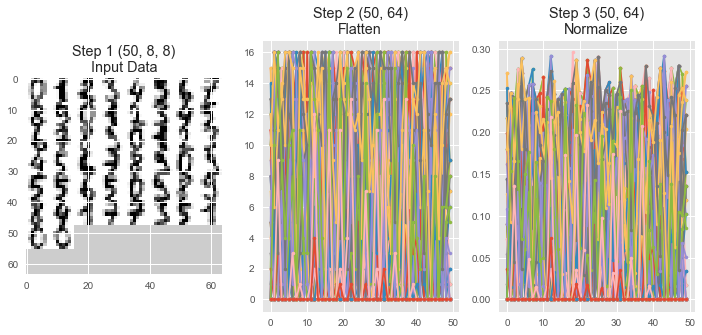

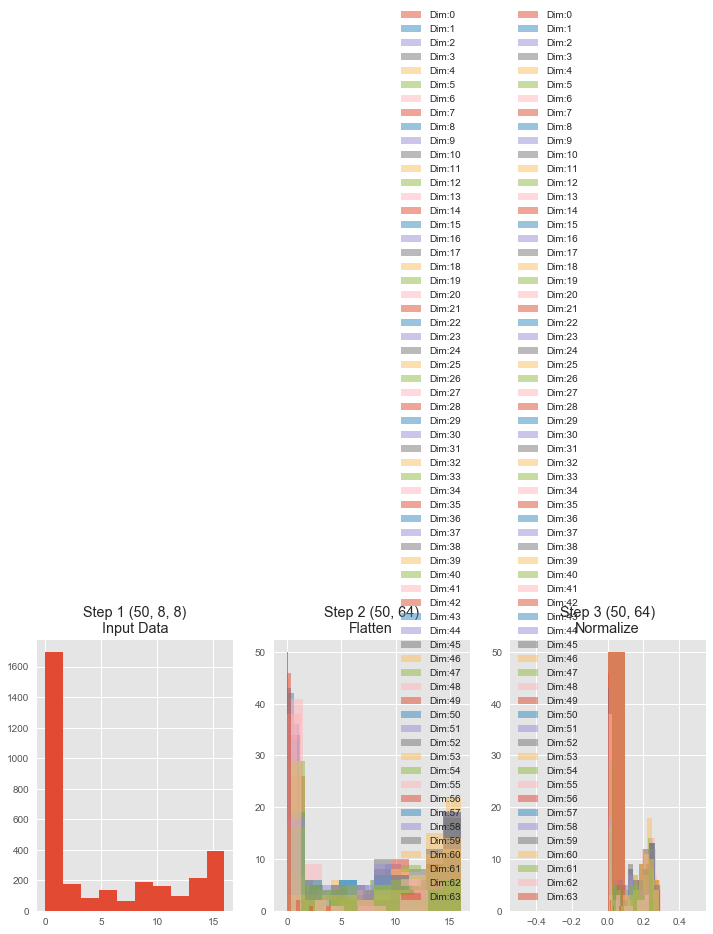

In [8]:
from pipe_utils import flatten_step
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
digit_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer())])
digit_pipe.fit(img_data)

show_pipe(digit_pipe, img_data)
show_pipe(digit_pipe, img_data, show_hist = True)

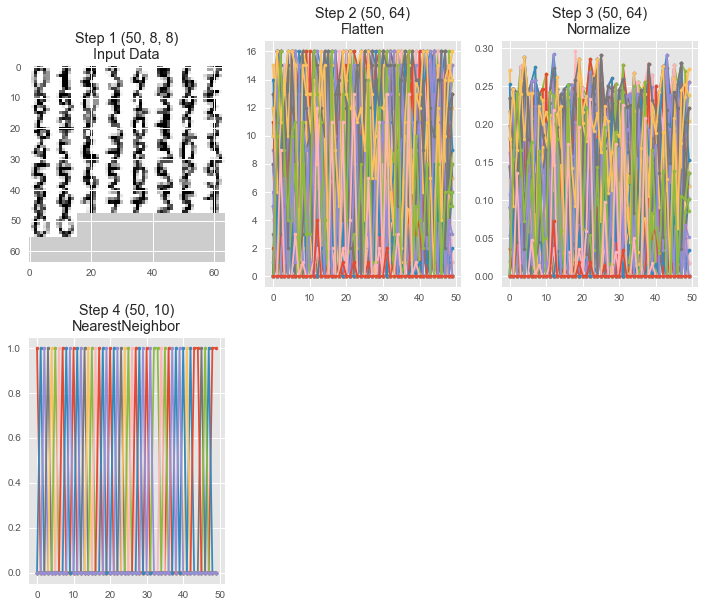

In [9]:
from sklearn.neighbors import KNeighborsClassifier

digit_class_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('NearestNeighbor', KNeighborsClassifier(1))])
digit_class_pipe.fit(img_data, digit_id)

show_pipe(digit_class_pipe, img_data)

In [10]:
from sklearn.metrics import accuracy_score
pred_digit = digit_class_pipe.predict(img_data)
print('%2.2f%% accuracy' % (100*accuracy_score(digit_id, pred_digit)))

100.00% accuracy


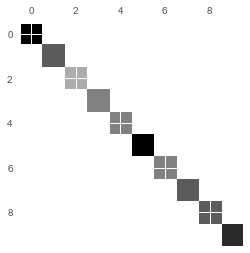

In [11]:
from sklearn.metrics import confusion_matrix

plt.matshow(confusion_matrix(digit_id, pred_digit))

In [12]:
from sklearn.metrics import classification_report
print(classification_report(digit_id, pred_digit))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         7
          1       1.00      1.00      1.00         5
          2       1.00      1.00      1.00         3
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         4
          5       1.00      1.00      1.00         7
          6       1.00      1.00      1.00         4
          7       1.00      1.00      1.00         5
          8       1.00      1.00      1.00         5
          9       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        50



# Wow! We've built an amazing algorithm!
## Let's patent it! Call Google!

Prediction: [8]
Real Value: 9


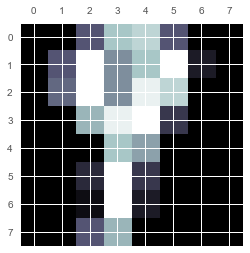

In [13]:
test_digit = np.array([[[ 0.,  0.,  6., 12., 13.,  6.,  0.,  0.],
        [ 0.,  6., 16.,  9., 12., 16.,  2.,  0.],
        [ 0.,  7., 16.,  9., 15., 13.,  0.,  0.],
        [ 0.,  0., 11., 15., 16.,  4.,  0.,  0.],
        [ 0.,  0.,  0., 12., 10.,  0.,  0.,  0.],
        [ 0.,  0.,  3., 16.,  4.,  0.,  0.,  0.],
        [ 0.,  0.,  1., 16.,  2.,  0.,  0.,  0.],
        [ 0.,  0.,  6., 11.,  0.,  0.,  0.,  0.]]])
plt.matshow(test_digit[0], cmap = 'bone')
print('Prediction:', digit_class_pipe.predict(test_digit))
print('Real Value:', 9)

# Training, Validation, and Testing


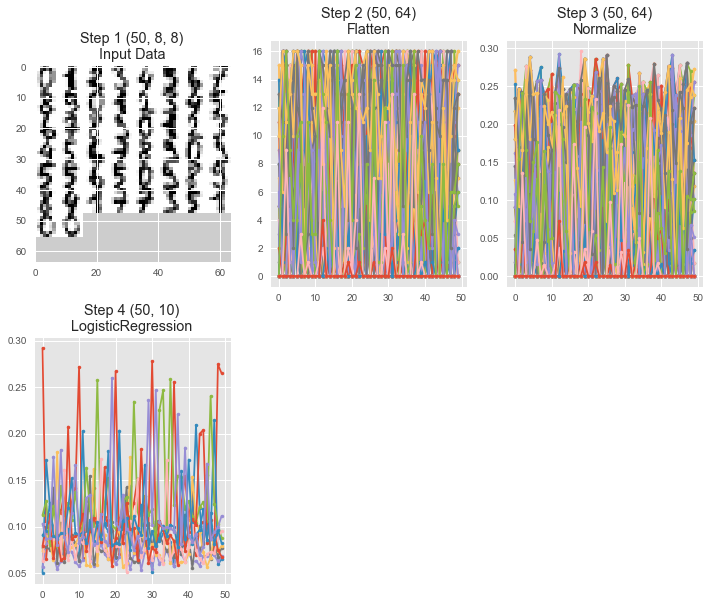

In [14]:
from sklearn.linear_model import LogisticRegression

digit_class_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('LogisticRegression', LogisticRegression())])
digit_class_pipe.fit(img_data, digit_id)

show_pipe(digit_class_pipe, img_data)

# Regression
For regression, we can see it very similarly to a classification but instead of trying to output discrete classes we can output on a continuous scale. So we can take the exact same task (digits) but instead of predicting the category we can predict the actual decimal number

In [15]:
%matplotlib inline
from pipe_utils import show_pipe, flatten_step
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
digit_ds = load_digits(return_X_y=False)

img_data = digit_ds.images[:50]
digit_id = digit_ds.target[:50]

valid_data = digit_ds.images[50:500]
valid_id = digit_ds.target[50:500]


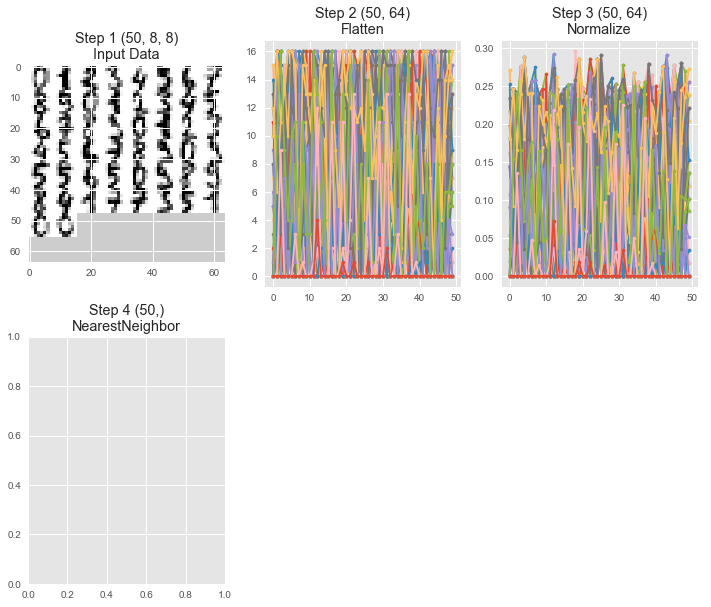

In [16]:
from sklearn.neighbors import KNeighborsRegressor

digit_regress_pipe = Pipeline([('Flatten', flatten_step),
                        ('Normalize', Normalizer()),
                      ('NearestNeighbor', KNeighborsRegressor(1))])
digit_regress_pipe.fit(img_data, digit_id)

show_pipe(digit_regress_pipe, img_data)

# Assessment
We can't use accuracy, ROC, precision, recall or any of these factors anymore since we don't have binary / true-or-false conditions we are trying to predict. We know have to go back to some of the initial metrics we covered in the first lectures.

$$ MSE = \frac{1}{N}\sum \left(y_{predicted} - y_{actual}\right)^2 $$
$$ MAE = \frac{1}{N}\sum |y_{predicted} - y_{actual}| $$

Text(0.5,1,'Predictions (Validation)\nMSE: 1.79 MAE: 0.42')

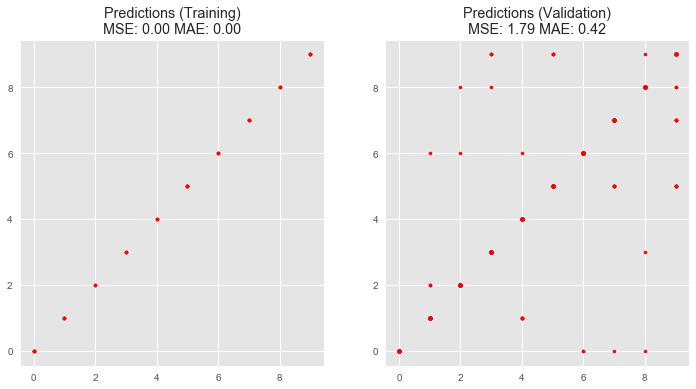

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
pred_train = digit_regress_pipe.predict(img_data)

ax1.plot(digit_id, pred_train, 'r.')
ax1.set_title('Predictions (Training)\nMSE: %2.2f MAE: %2.2f' % (np.mean(np.square(pred_train-digit_id)), 
                                                                np.mean(np.abs(pred_train-digit_id))))

pred_valid = digit_regress_pipe.predict(valid_data)
ax2.plot(valid_id, 
         pred_valid, 'r.')
ax2.set_title('Predictions (Validation)\nMSE: %2.2f MAE: %2.2f' % (np.mean(np.square(pred_valid-valid_id)), 
                                                                np.mean(np.abs(pred_valid-valid_id))))

# Where segmentation fails: Brain Cortex

![Cortex Image](ext-figures/cortex_mask.png)

- The cortex is barely visible to the human eye
- Tiny structures hint at where cortex is located

*** 

- A simple threshold is insufficient to finding the cortical structures
- Other filtering techniques are unlikely to magicially fix this problem


(173, 135) (173, 135)


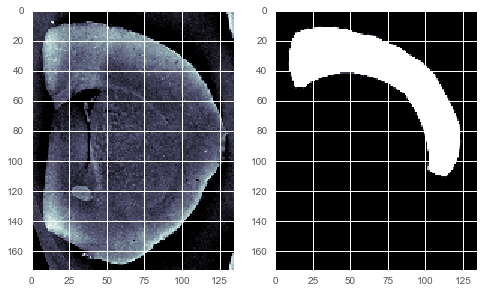

In [18]:
%matplotlib inline
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
cortex_img = imread("ext-figures/example_poster.tif")[::6, ::6]
cortex_mask = imread("ext-figures/example_poster_mask.tif")[::3, ::3, 0]
print(cortex_img.shape, cortex_mask.shape)
np.random.seed(2018)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(cortex_img, cmap = 'bone')
ax2.imshow(cortex_mask, cmap = 'bone')

In [19]:
train_img, valid_img = cortex_img[:,:100], cortex_img[:,100:]
train_mask, valid_mask = cortex_mask[:,:100], cortex_mask[:,100:]
print('Training', train_img.shape, train_mask.shape)
print('Validation Data', valid_img.shape, valid_mask.shape)

Training (173, 100) (173, 100)
Validation Data (173, 35) (173, 35)


Text(0.5,1,'Validation Mask')

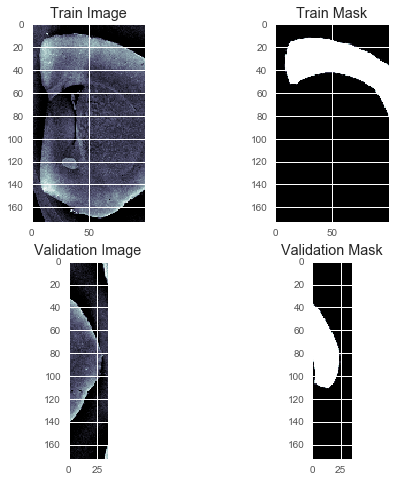

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(valid_img, cmap = 'bone')
ax3.set_title('Validation Image')
ax4.imshow(valid_mask, cmap = 'bone')
ax4.set_title('Validation Mask')

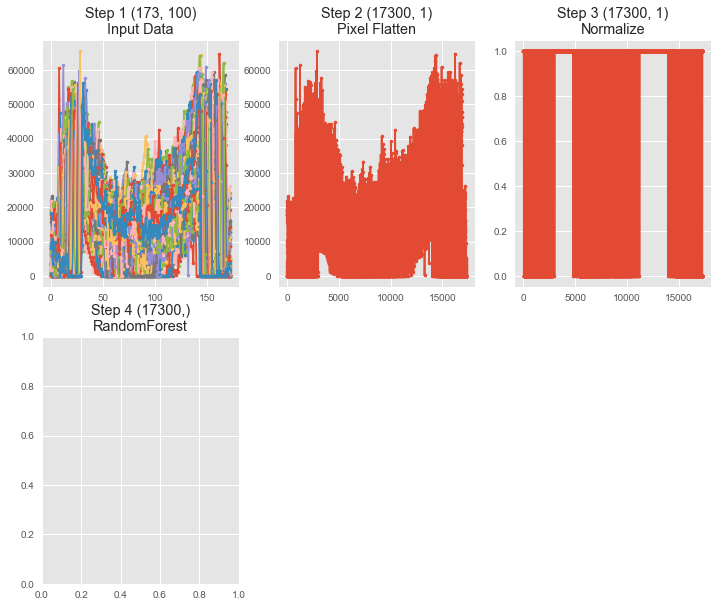

In [21]:
from pipe_utils import px_flatten_step, show_pipe, fit_img_pipe
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

rf_seg_model = Pipeline([('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                       ('RandomForest', RandomForestRegressor())
                      ])
    
pred_func = fit_img_pipe(rf_seg_model, train_img, train_mask)
show_pipe(rf_seg_model, train_img)

Text(0.5,1,'Prediction Mask')

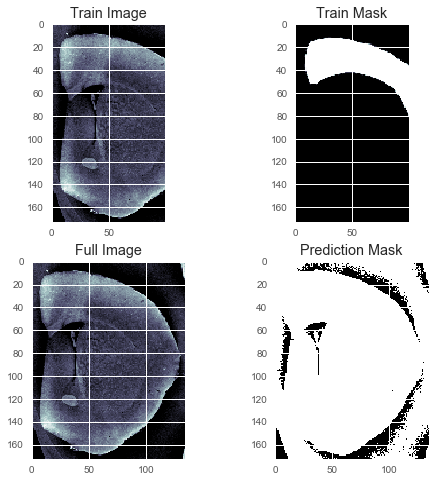

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask')

# Include Position Information

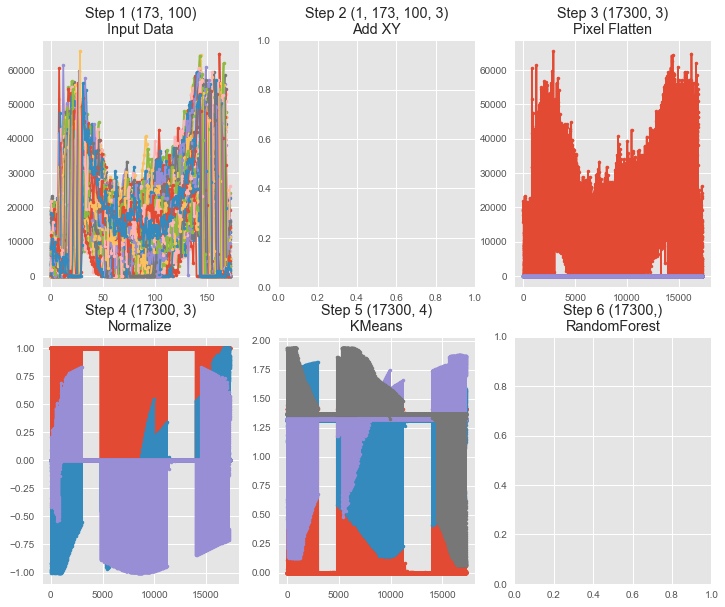

In [23]:
from pipe_utils import xy_step

rf_xyseg_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('KMeans', KMeans(4)),
                       ('RandomForest', RandomForestRegressor())
                      ])


pred_func = fit_img_pipe(rf_xyseg_model, train_img, train_mask)
show_pipe(rf_xyseg_model, train_img)

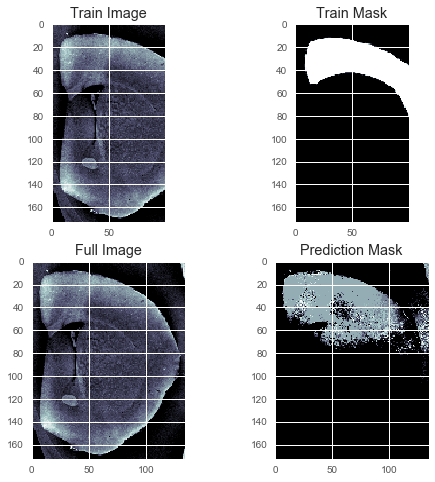

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');

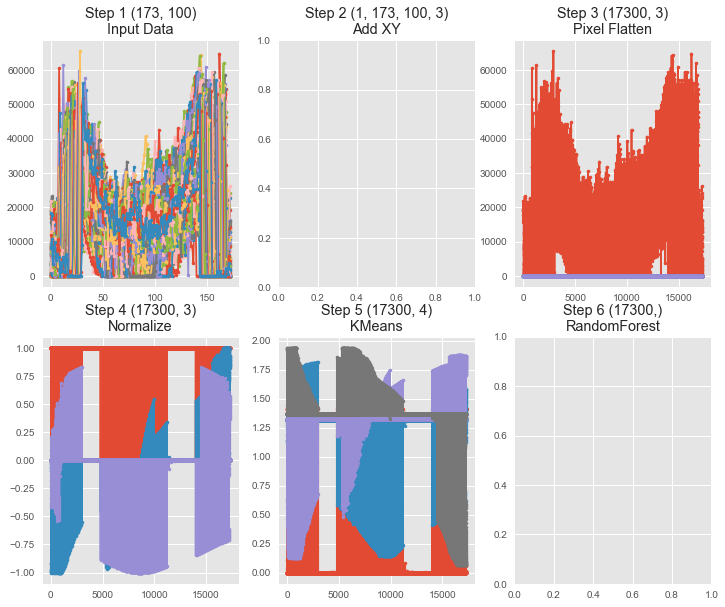

In [25]:
from sklearn.cluster import KMeans
rf_xyseg_k_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('KMeans', KMeans(4)),
                       ('RandomForest', RandomForestRegressor())
                      ])

pred_func = fit_img_pipe(rf_xyseg_k_model, train_img, train_mask)
show_pipe(rf_xyseg_k_model, train_img);

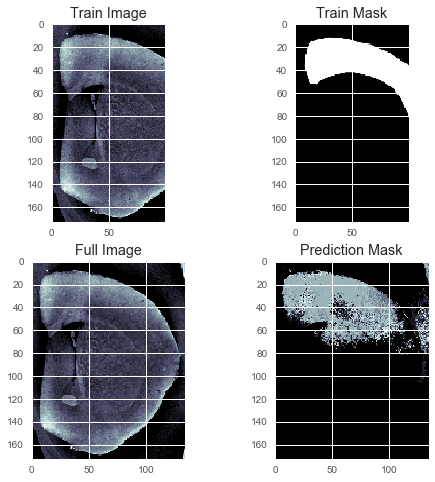

In [26]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');

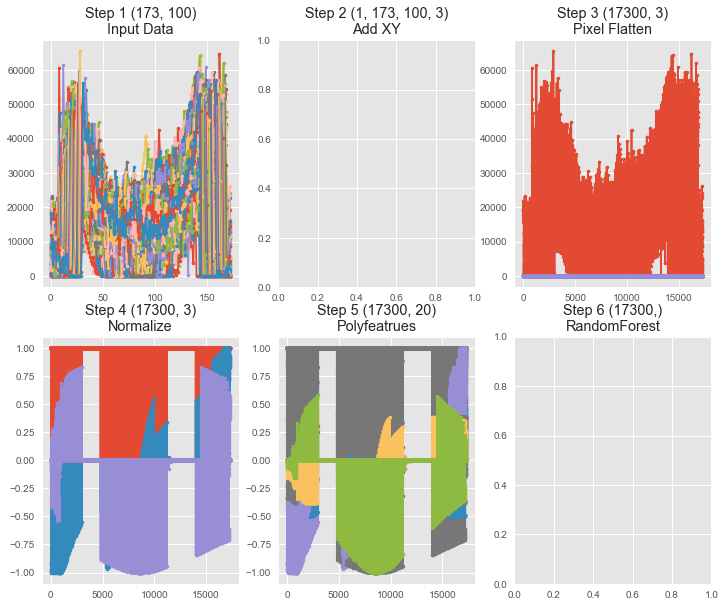

In [27]:
from sklearn.preprocessing import PolynomialFeatures
rf_xyseg_py_model = Pipeline([('Add XY', xy_step),
                         ('Pixel Flatten', px_flatten_step),
                        ('Normalize', Normalizer()),
                        ('Polyfeatrues', PolynomialFeatures(3)),
                       ('RandomForest', RandomForestRegressor())
                      ])

pred_func = fit_img_pipe(rf_xyseg_py_model, train_img, train_mask)
show_pipe(rf_xyseg_py_model, train_img);

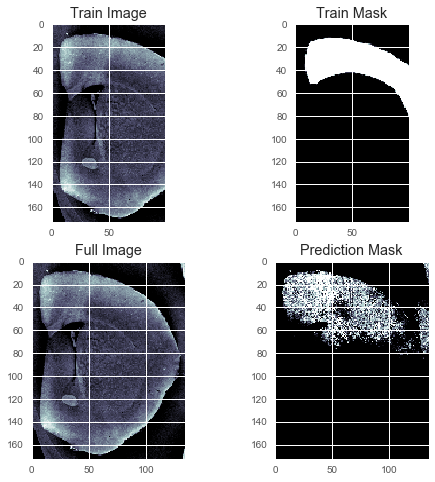

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8, 8), dpi = 72)
ax1.imshow(train_img, cmap = 'bone')
ax1.set_title('Train Image')
ax2.imshow(train_mask, cmap = 'bone')
ax2.set_title('Train Mask')

ax3.imshow(cortex_img, cmap = 'bone')
ax3.set_title('Full Image')

ax4.imshow(pred_func(cortex_img)[:,:,0], 
           cmap = 'bone')
ax4.set_title('Prediction Mask');